In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm
from sklearn.inspection import DecisionBoundaryDisplay

iris = datasets.load_iris() 

X = iris.data[:, :2]  # we only take the first two features for easy visualization
y = iris.target


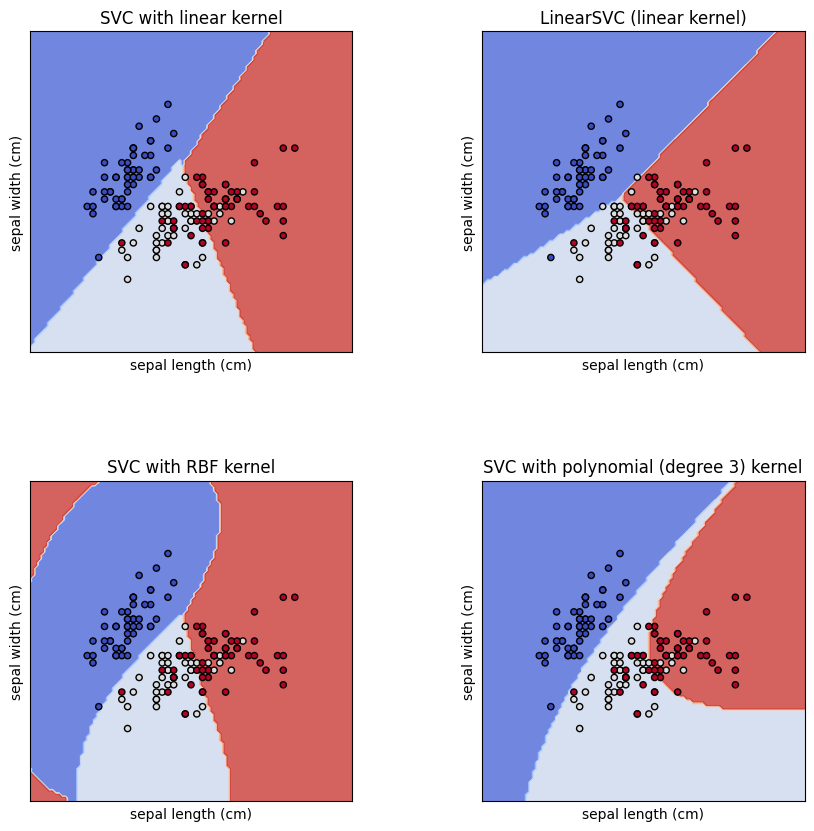

In [2]:
C = 1.0
models = (svm.SVC(kernel='linear', C=C),
        svm.LinearSVC(C=C, max_iter=10000),
        svm.SVC(kernel='rbf', gamma=0.7, C=C),
        svm.SVC(kernel='poly', degree=3, gamma="auto", C=C))

models = (clf.fit(X, y) for clf in models)

titles = ('SVC with linear kernel',
        'LinearSVC (linear kernel)',
        'SVC with RBF kernel',
        'SVC with polynomial (degree 3) kernel')

fig, sub = plt.subplots(2, 2, figsize=(10, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

X0, X1 = X[:, 0], X[:, 1]

for clf, title, ax in zip(models, titles, sub.flatten()):
    disp = DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        response_method="predict",
        cmap=plt.cm.coolwarm,
        alpha=0.8,
        ax=ax,
        xlabel=iris.feature_names[0],
        ylabel=iris.feature_names[1],
    )
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s= 20, edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

plt.show()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from svm_models import NaiveSVM, ProbSVM, KNNSVM, SKiP
from sklearn.svm import SVC
from datasets import inject_noise

In [46]:
X, y = make_classification(
    n_samples=300, n_features=2, n_redundant=0, n_informative=2,
    n_clusters_per_class=1, class_sep=1.5, random_state=0
)

# 2) split + scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=0
)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

In [51]:
# 3) inject noise
#    - feature_noise: 잘 분리되어있으나 클래스 센트로이드와 거리가 먼 데이터 (피쳐 노이즈)
#    - label_noise: 라벨이 뒤집힌 데이터 (라벨 노이즈)

X_noisy_train, y_noisy_train = inject_noise(
  X_train, y_train,
  feature_noise=0.3, label_noise=0.3,
  random_state=42
)

Test acc: 0.9444444444444444


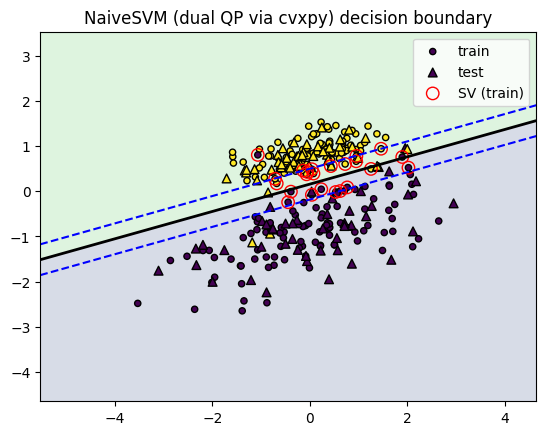

In [52]:
# Naive SVM

clf_naive = NaiveSVM(C=1, fit_intercept=True)
clf_naive.fit(X_train, y_train)
print("Test acc:", (clf_naive.predict(X_test) == y_test).mean())

xx, yy = np.meshgrid(
    np.linspace(X_train[:,0].min()-2, X_train[:,0].max()+2, 300),
    np.linspace(X_train[:,1].min()-2, X_train[:,1].max()+2, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf_naive.decision_function(grid).reshape(xx.shape)

plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_naive.support_
plt.scatter(X_train[sv,0], X_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')
plt.legend()
plt.title("NaiveSVM (dual QP via cvxpy) decision boundary")
plt.show()


Test acc: 0.9333333333333333


C:\Users\ohdoy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


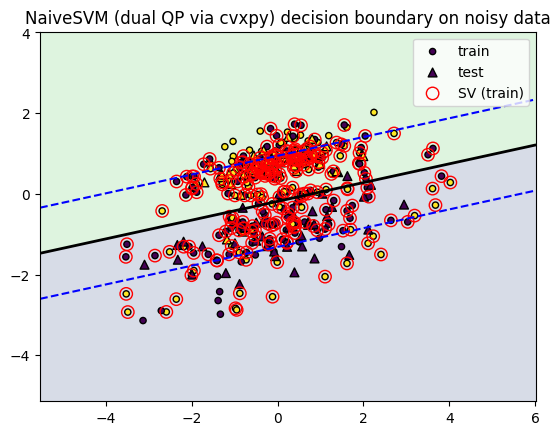

In [53]:
# Naive SVM on noisy data

clf_naive = NaiveSVM(C=1, fit_intercept=True)
clf_naive.fit(X_noisy_train, y_noisy_train)
print("Test acc:", (clf_naive.predict(X_test) == y_test).mean())

xx, yy = np.meshgrid(
    np.linspace(X_noisy_train[:,0].min()-2, X_noisy_train[:,0].max()+2, 300),
    np.linspace(X_noisy_train[:,1].min()-2, X_noisy_train[:,1].max()+2, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf_naive.decision_function(grid).reshape(xx.shape)

plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_noisy_train[:,0], X_noisy_train[:,1], c=y_noisy_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_naive.support_
plt.scatter(X_noisy_train[sv,0], X_noisy_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')
plt.legend()
plt.title("NaiveSVM (dual QP via cvxpy) decision boundary on noisy data")
plt.show()

Test acc: 0.9444444444444444


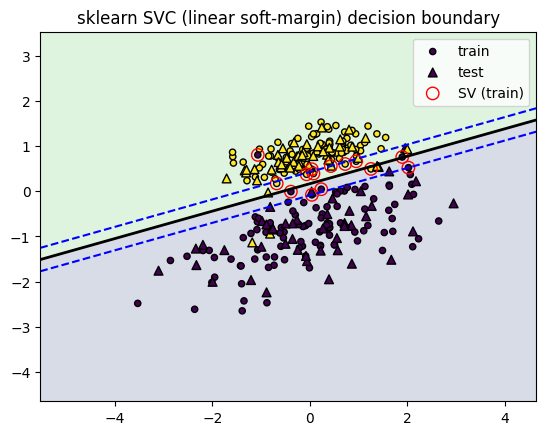

In [54]:
# Skleran SVC

clf_sklearn = SVC(kernel='linear', C=10)
clf_sklearn.fit(X_train, y_train)
print("Test acc:", (clf_sklearn.predict(X_test) == y_test).mean())

# 4) 결정경계 그리드
xx, yy = np.meshgrid(
    np.linspace(X_train[:,0].min()-2, X_train[:,0].max()+2, 300),
    np.linspace(X_train[:,1].min()-2, X_train[:,1].max()+2, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf_sklearn.decision_function(grid).reshape(xx.shape)

# 5) 시각화
plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')

# support vectors (train 기준)
sv = clf_sklearn.support_
plt.scatter(X_train[sv,0], X_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')

plt.legend()
plt.title("sklearn SVC (linear soft-margin) decision boundary")
plt.show()


Test acc: 0.9444444444444444


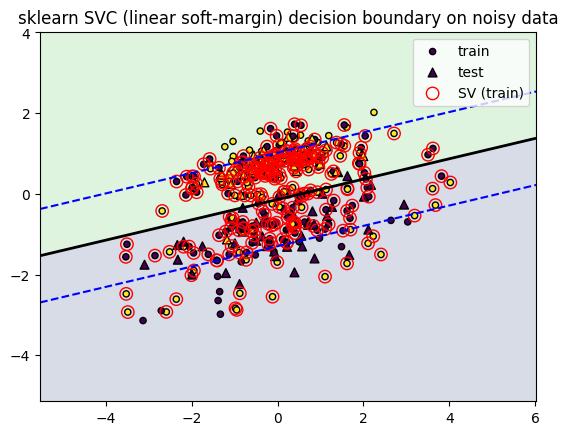

In [55]:
# Skleran SVC on noisy data

clf_sklearn = SVC(kernel='linear', C=10)
clf_sklearn.fit(X_noisy_train, y_noisy_train)
print("Test acc:", (clf_sklearn.predict(X_test) == y_test).mean())

# 4) 결정경계 그리드
xx, yy = np.meshgrid(
    np.linspace(X_noisy_train[:,0].min()-2, X_noisy_train[:,0].max()+2, 300),
    np.linspace(X_noisy_train[:,1].min()-2, X_noisy_train[:,1].max()+2, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf_sklearn.decision_function(grid).reshape(xx.shape)

# 5) 시각화
plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_noisy_train[:,0], X_noisy_train[:,1], c=y_noisy_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')

# support vectors (train 기준)
sv = clf_sklearn.support_
plt.scatter(X_noisy_train[sv,0], X_noisy_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')

plt.legend()
plt.title("sklearn SVC (linear soft-margin) decision boundary on noisy data")
plt.show()

Test acc: 0.9666666666666667


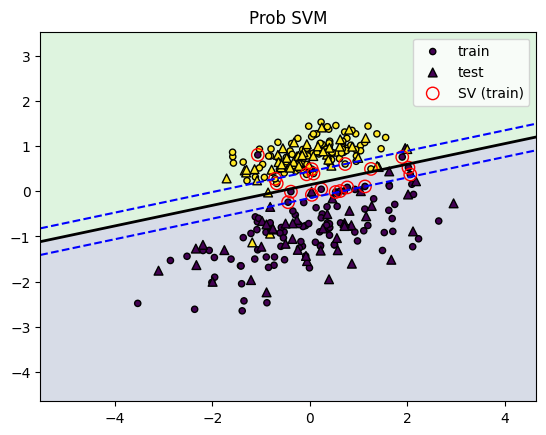

In [59]:
# Prob SVM

clf_prob = ProbSVM(C=10, fit_intercept=True)
clf_prob.fit(X_train, y_train)
print("Test acc:", (clf_prob.predict(X_test) == y_test).mean())

xx, yy = np.meshgrid(
    np.linspace(X_train[:,0].min()-2, X_train[:,0].max()+2, 300),
    np.linspace(X_train[:,1].min()-2, X_train[:,1].max()+2, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf_prob.decision_function(grid).reshape(xx.shape)

plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_prob.support_
plt.scatter(X_train[sv,0], X_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')
plt.legend()
plt.title("Prob SVM")
plt.show()


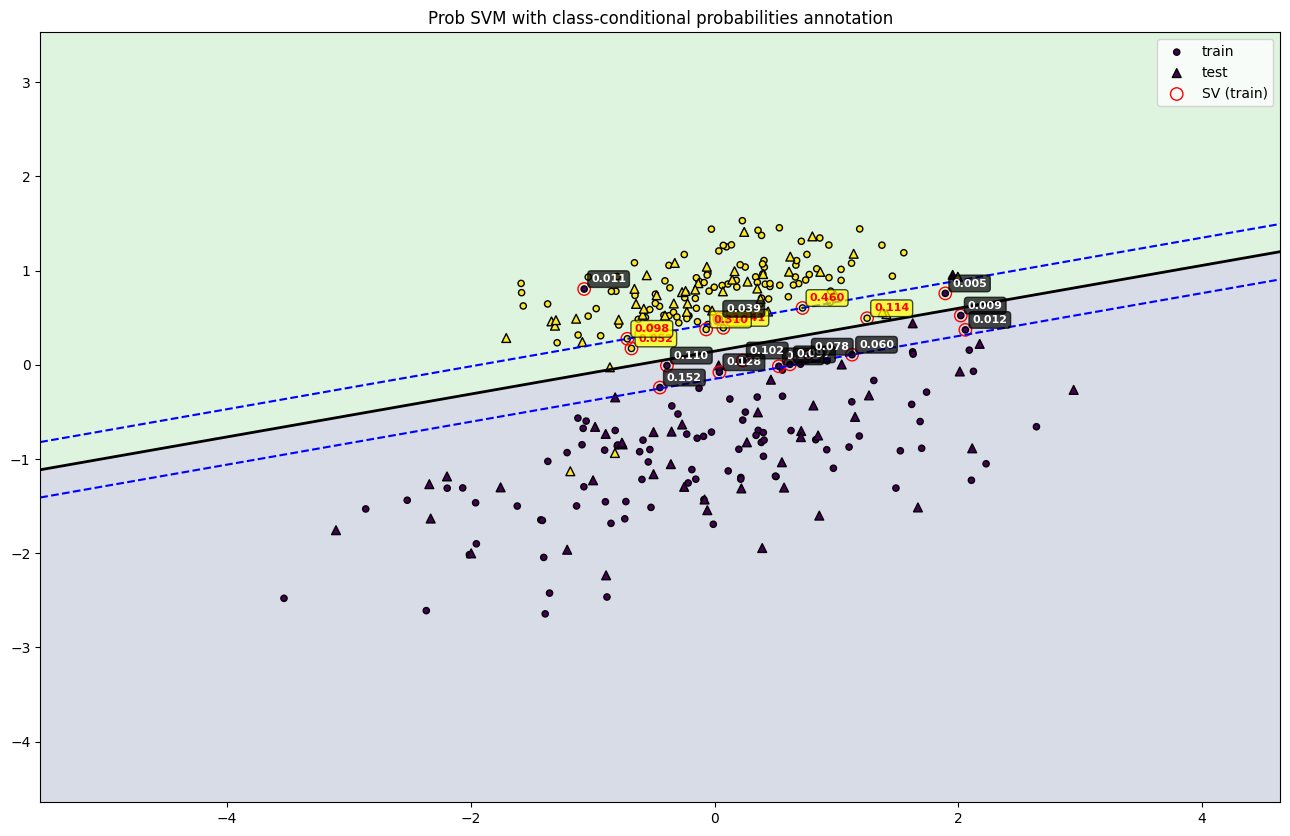

In [60]:
# Prob SVM visualization with probability annotations


plt.figure(figsize=(16, 10))
plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_prob.support_
plt.scatter(X_train[sv,0], X_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')

# classes = np.unique(y_train)
# n_samples = len(y_train)
# p_i = np.zeros(n_samples)

# w = 0.9
# c = (1-w)*np.array(to_rgb('green')) + w*np.array(to_rgb('yellow'))

# for cls in classes:
#     cls_mask = (y_train == cls)
#     prior = np.sum(cls_mask) / n_samples

#     X_cls = X_train[cls_mask]
#     mean = np.mean(X_cls, axis=0)
#     if cls == 0:
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = 'black', linestyle='solid', alpha = 0.4)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = 'black', linestyle='solid', alpha = 0.4)
#     else :
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = c, linestyle='solid', alpha = 0.6)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = c, linestyle='solid', alpha = 0.6)



# Annotate support vectors with their class-conditional probabilities
for idx in sv:
    p_val = clf_prob.p_i_[idx]
    if y_train[idx] == 0:
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_train[idx, 0], X_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    else :
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_train[idx, 0], X_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='red', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.legend()
plt.title("Prob SVM with class-conditional probabilities annotation")
plt.show()


C:\Users\ohdoy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Test acc: 0.9444444444444444


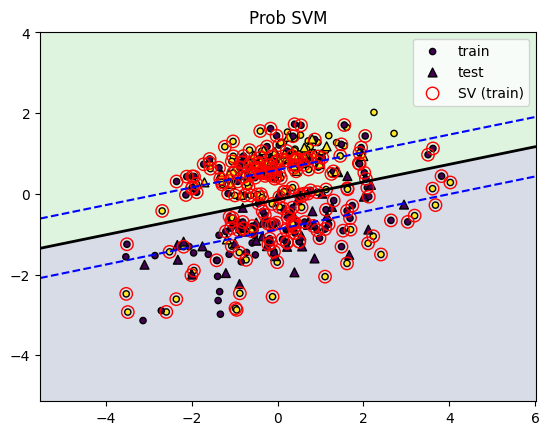

In [61]:
# Prob SVM on noisy data

clf_prob = ProbSVM(C=10, fit_intercept=True)
clf_prob.fit(X_noisy_train, y_noisy_train)
print("Test acc:", (clf_prob.predict(X_test) == y_test).mean())

xx, yy = np.meshgrid(
    np.linspace(X_noisy_train[:,0].min()-2, X_noisy_train[:,0].max()+2, 300),
    np.linspace(X_noisy_train[:,1].min()-2, X_noisy_train[:,1].max()+2, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf_prob.decision_function(grid).reshape(xx.shape)

plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_noisy_train[:,0], X_noisy_train[:,1], c=y_noisy_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_prob.support_
plt.scatter(X_noisy_train[sv,0], X_noisy_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')
plt.legend()
plt.title("Prob SVM")
plt.show()


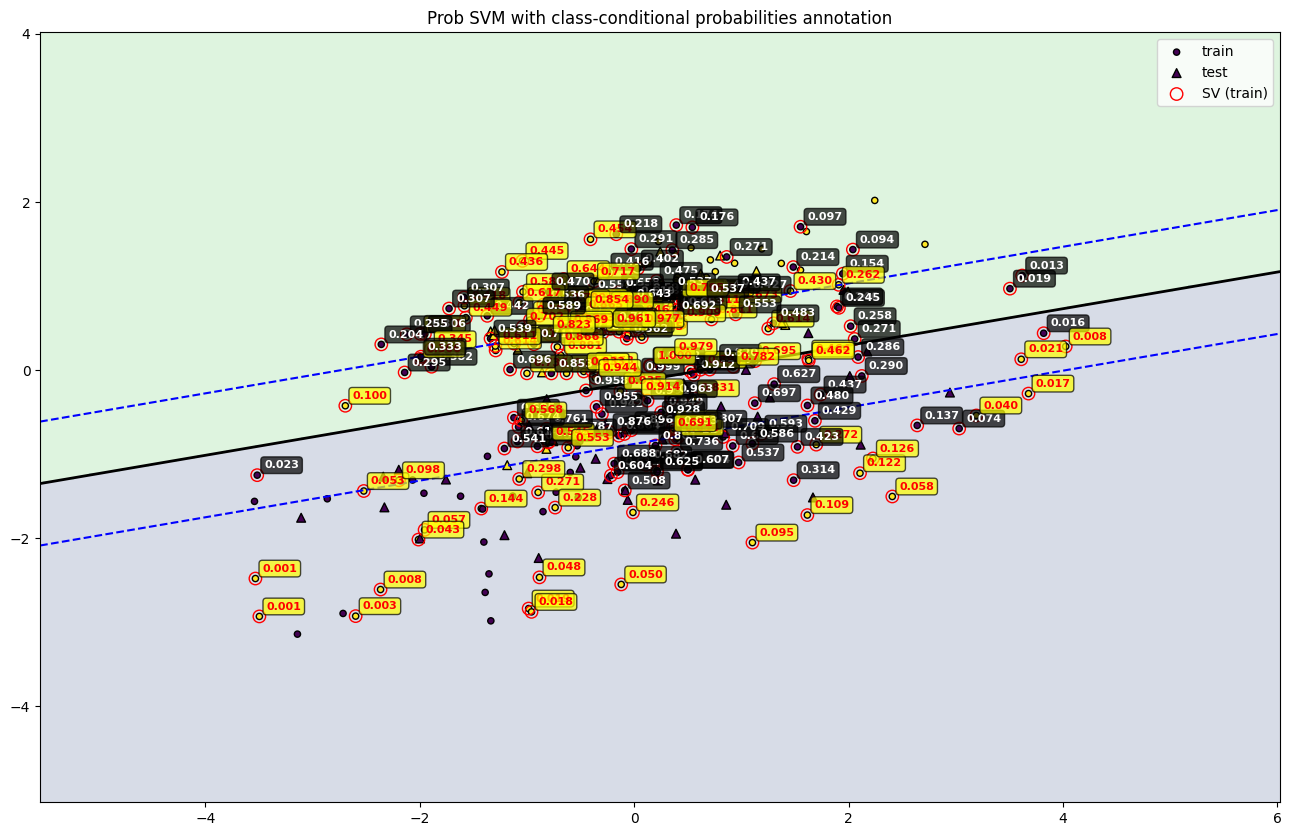

In [63]:
# Prob SVM visualization with probability annotations on noisy data


plt.figure(figsize=(16, 10))
plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_noisy_train[:,0], X_noisy_train[:,1], c=y_noisy_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_prob.support_
plt.scatter(X_noisy_train[sv,0], X_noisy_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')

# classes = np.unique(y_train)
# n_samples = len(y_train)
# p_i = np.zeros(n_samples)

# w = 0.9
# c = (1-w)*np.array(to_rgb('green')) + w*np.array(to_rgb('yellow'))

# for cls in classes:
#     cls_mask = (y_train == cls)
#     prior = np.sum(cls_mask) / n_samples

#     X_cls = X_train[cls_mask]
#     mean = np.mean(X_cls, axis=0)
#     if cls == 0:
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = 'black', linestyle='solid', alpha = 0.4)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = 'black', linestyle='solid', alpha = 0.4)
#     else :
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = c, linestyle='solid', alpha = 0.6)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = c, linestyle='solid', alpha = 0.6)



# Annotate support vectors with their class-conditional probabilities
for idx in sv:
    p_val = clf_prob.p_i_[idx]
    if y_noisy_train[idx] == 0:
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_noisy_train[idx, 0], X_noisy_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    else :
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_noisy_train[idx, 0], X_noisy_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='red', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.legend()
plt.title("Prob SVM with class-conditional probabilities annotation")
plt.show()


Test acc: 0.9444444444444444


/home/suri/anaconda3/envs/skip/lib/python3.12/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


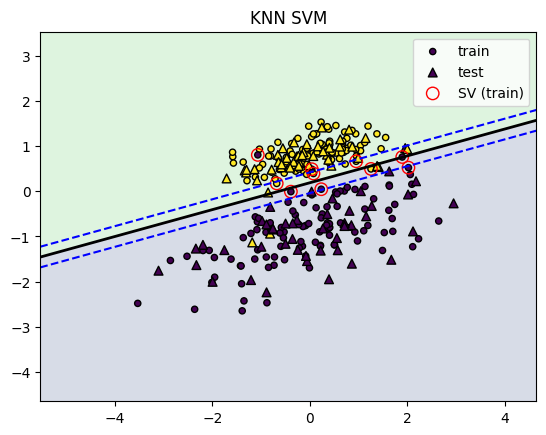

In [36]:
# KNN SVM

clf_knn = KNNSVM(C=10, fit_intercept=True)
clf_knn.fit(X_train, y_train)
print("Test acc:", (clf_knn.predict(X_test) == y_test).mean())

xx, yy = np.meshgrid(
    np.linspace(X_train[:,0].min()-2, X_train[:,0].max()+2, 300),
    np.linspace(X_train[:,1].min()-2, X_train[:,1].max()+2, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf_knn.decision_function(grid).reshape(xx.shape)

plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_knn.support_
plt.scatter(X_train[sv,0], X_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')
plt.legend()
plt.title("KNN SVM")
plt.show()


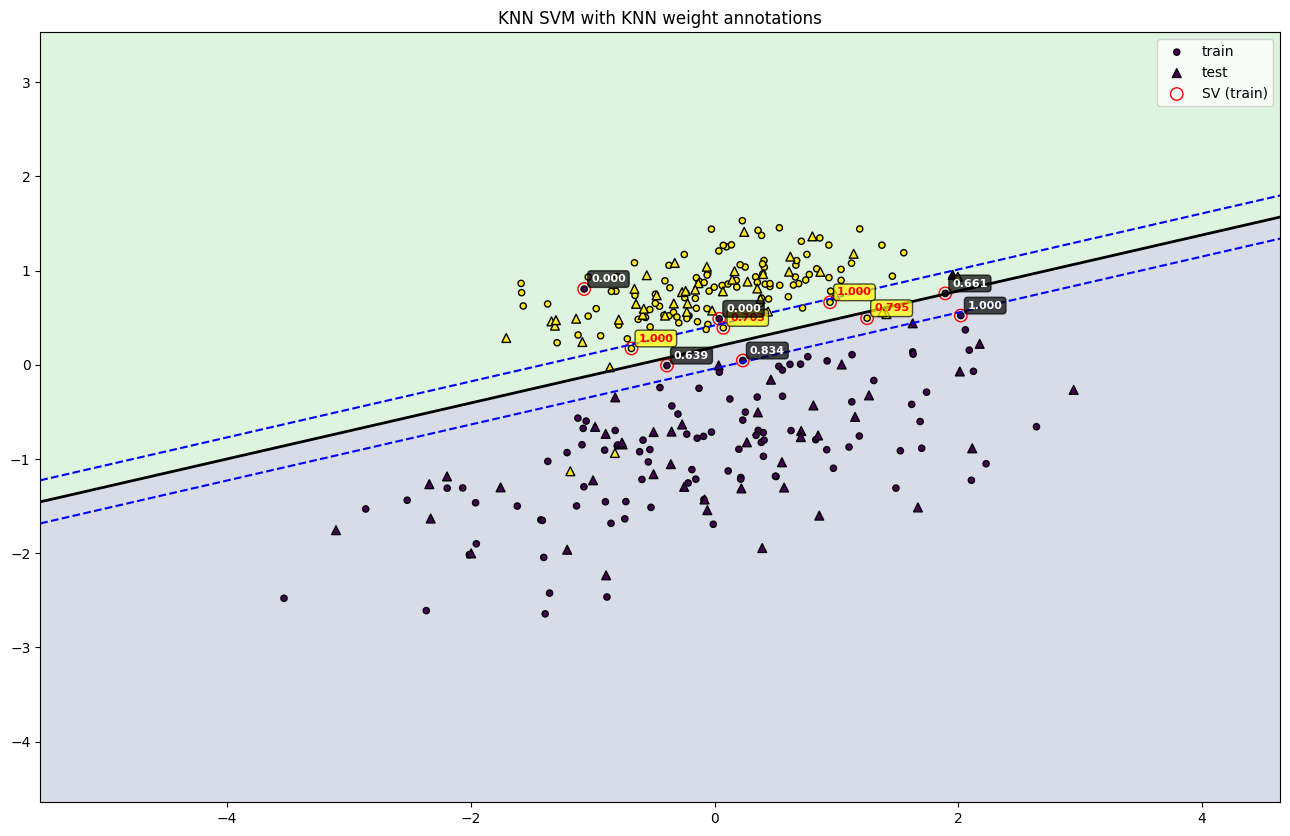

In [37]:
# KNN SVM visualization with KNN weight annotations
plt.figure(figsize=(16, 10))
plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_knn.support_
plt.scatter(X_train[sv,0], X_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')

# classes = np.unique(y_train)
# n_samples = len(y_train)
# p_i = np.zeros(n_samples)

# w = 0.9
# c = (1-w)*np.array(to_rgb('green')) + w*np.array(to_rgb('yellow'))

# for cls in classes:
#     cls_mask = (y_train == cls)
#     prior = np.sum(cls_mask) / n_samples

#     X_cls = X_train[cls_mask]
#     mean = np.mean(X_cls, axis=0)
#     if cls == 0:
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = 'black', linestyle='solid', alpha = 0.4)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = 'black', linestyle='solid', alpha = 0.4)
#     else :
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = c, linestyle='solid', alpha = 0.6)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = c, linestyle='solid', alpha = 0.6)



# Annotate support vectors with their KNN weights
for idx in sv:
    p_val = clf_knn.w_i_[idx]
    if y_train[idx] == 0:
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_train[idx, 0], X_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    else :
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_train[idx, 0], X_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='red', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.legend()
plt.title("KNN SVM with KNN weight annotations")
plt.show()


C:\Users\ohdoy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Test acc: 0.9333333333333333


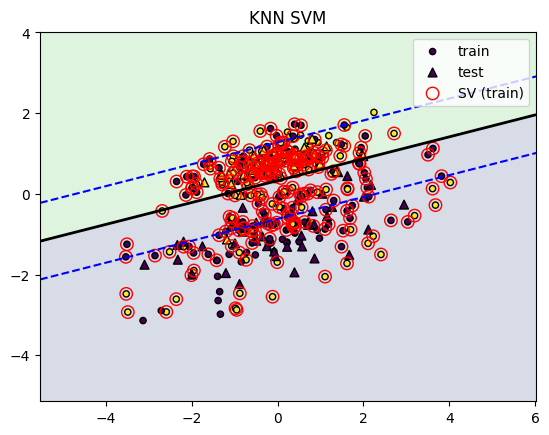

In [64]:
# KNN SVM on noisy data

clf_knn = KNNSVM(C=10, fit_intercept=True)
clf_knn.fit(X_noisy_train, y_noisy_train)
print("Test acc:", (clf_knn.predict(X_test) == y_test).mean())

xx, yy = np.meshgrid(
    np.linspace(X_noisy_train[:,0].min()-2, X_noisy_train[:,0].max()+2, 300),
    np.linspace(X_noisy_train[:,1].min()-2, X_noisy_train[:,1].max()+2, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf_knn.decision_function(grid).reshape(xx.shape)

plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_noisy_train[:,0], X_noisy_train[:,1], c=y_noisy_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_knn.support_
plt.scatter(X_noisy_train[sv,0], X_noisy_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')
plt.legend()
plt.title("KNN SVM")
plt.show()

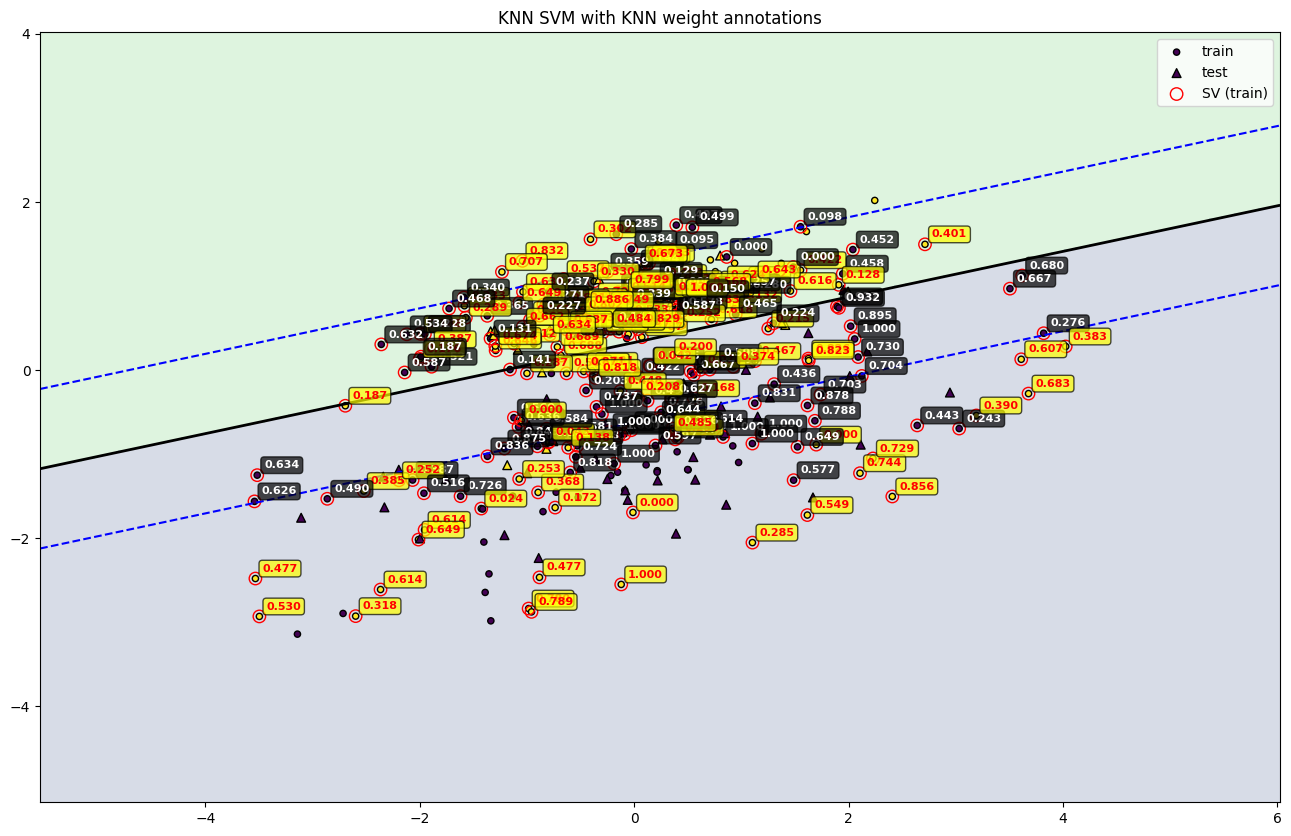

In [65]:
# KNN SVM visualization with KNN weight annotations on noisy data
plt.figure(figsize=(16, 10))
plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_noisy_train[:,0], X_noisy_train[:,1], c=y_noisy_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_knn.support_
plt.scatter(X_noisy_train[sv,0], X_noisy_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')

# classes = np.unique(y_train)
# n_samples = len(y_train)
# p_i = np.zeros(n_samples)

# w = 0.9
# c = (1-w)*np.array(to_rgb('green')) + w*np.array(to_rgb('yellow'))

# for cls in classes:
#     cls_mask = (y_train == cls)
#     prior = np.sum(cls_mask) / n_samples

#     X_cls = X_train[cls_mask]
#     mean = np.mean(X_cls, axis=0)
#     if cls == 0:
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = 'black', linestyle='solid', alpha = 0.4)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = 'black', linestyle='solid', alpha = 0.4)
#     else :
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = c, linestyle='solid', alpha = 0.6)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = c, linestyle='solid', alpha = 0.6)



# Annotate support vectors with their KNN weights
for idx in sv:
    p_val = clf_knn.w_i_[idx]
    if y_noisy_train[idx] == 0:
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_noisy_train[idx, 0], X_noisy_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    else :
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_noisy_train[idx, 0], X_noisy_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='red', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.legend()
plt.title("KNN SVM with KNN weight annotations")
plt.show()


Test acc: 0.9666666666666667


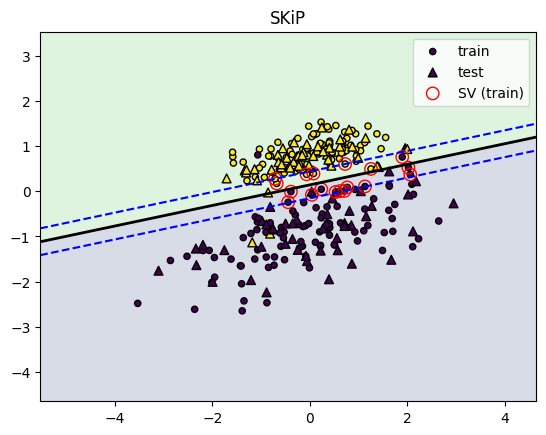

In [38]:
# SKiP

clf_skip = SKiP(C=10, fit_intercept=True)
clf_skip.fit(X_train, y_train)
print("Test acc:", (clf_skip.predict(X_test) == y_test).mean())

xx, yy = np.meshgrid(
    np.linspace(X_train[:,0].min()-2, X_train[:,0].max()+2, 300),
    np.linspace(X_train[:,1].min()-2, X_train[:,1].max()+2, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf_skip.decision_function(grid).reshape(xx.shape)

plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_skip.support_
plt.scatter(X_train[sv,0], X_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')
plt.legend()
plt.title("SKiP")
plt.show()

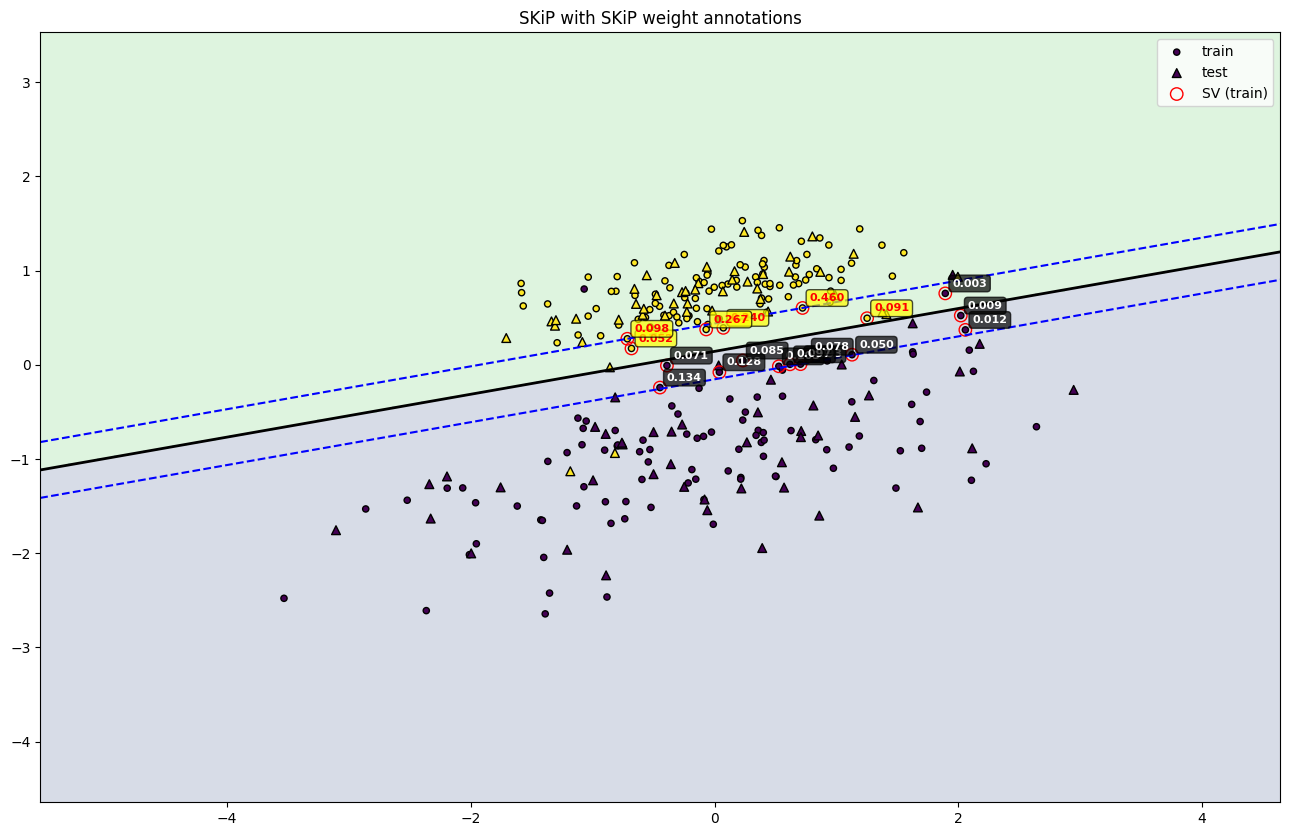

In [39]:
# KNN SVM visualization with KNN weight annotations
plt.figure(figsize=(16, 10))
plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_skip.support_
plt.scatter(X_train[sv,0], X_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')

# classes = np.unique(y_train)
# n_samples = len(y_train)
# p_i = np.zeros(n_samples)

# w = 0.9
# c = (1-w)*np.array(to_rgb('green')) + w*np.array(to_rgb('yellow'))

# for cls in classes:
#     cls_mask = (y_train == cls)
#     prior = np.sum(cls_mask) / n_samples

#     X_cls = X_train[cls_mask]
#     mean = np.mean(X_cls, axis=0)
#     if cls == 0:
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = 'black', linestyle='solid', alpha = 0.4)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = 'black', linestyle='solid', alpha = 0.4)
#     else :
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = c, linestyle='solid', alpha = 0.6)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = c, linestyle='solid', alpha = 0.6)



# Annotate support vectors with their KNN weights
for idx in sv:
    p_val = clf_skip.w_i_[idx] * clf_skip.p_i_[idx]
    if y_train[idx] == 0:
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_train[idx, 0], X_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    else :
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_train[idx, 0], X_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='red', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.legend()
plt.title("SKiP with SKiP weight annotations")
plt.show()

C:\Users\ohdoy\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cvxpy\problems\problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Test acc: 0.9


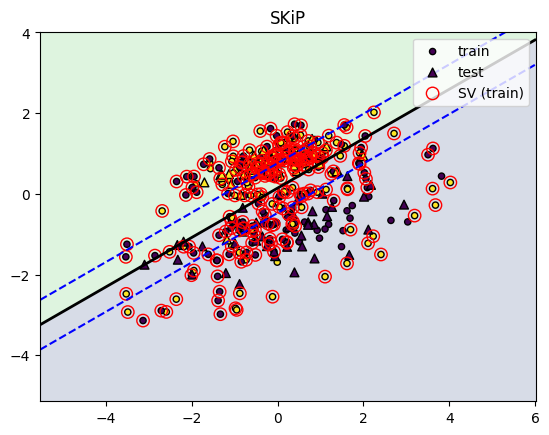

In [66]:
# SKiP on noisy data

clf_skip = SKiP(C=10, fit_intercept=True)
clf_skip.fit(X_noisy_train, y_noisy_train)
print("Test acc:", (clf_skip.predict(X_test) == y_test).mean())

xx, yy = np.meshgrid(
    np.linspace(X_noisy_train[:,0].min()-2, X_noisy_train[:,0].max()+2, 300),
    np.linspace(X_noisy_train[:,1].min()-2, X_noisy_train[:,1].max()+2, 300)
)
grid = np.c_[xx.ravel(), yy.ravel()]
zz = clf_skip.decision_function(grid).reshape(xx.shape)

plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_noisy_train[:,0], X_noisy_train[:,1], c=y_noisy_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_skip.support_
plt.scatter(X_noisy_train[sv,0], X_noisy_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')
plt.legend()
plt.title("SKiP")
plt.show()

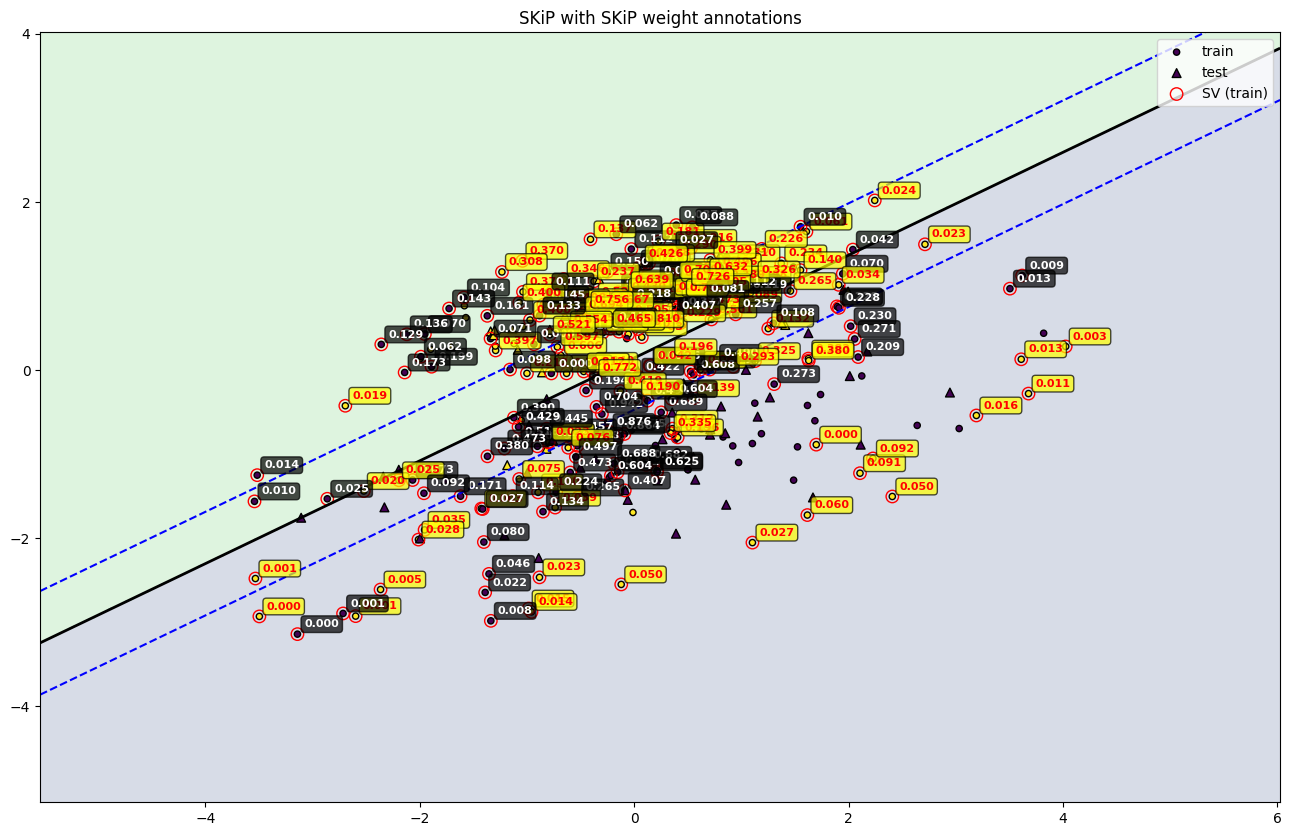

In [68]:
# KNN SVM visualization with KNN weight annotations on noisy data
plt.figure(figsize=(16, 10))
plt.contourf(xx, yy, zz >= 0, alpha=0.2)
plt.contour(xx, yy, zz, levels=[0], linewidths=2, colors='black')
plt.contour(xx, yy, zz, levels=[-1, 1], linewidths=1.5, colors='blue', linestyles='dashed')
plt.scatter(X_noisy_train[:,0], X_noisy_train[:,1], c=y_noisy_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, s=40, marker='^', edgecolor='k', label='test')
sv = clf_skip.support_
plt.scatter(X_noisy_train[sv,0], X_noisy_train[sv,1], s=80, facecolors='none', edgecolors='r', label='SV (train)')

# classes = np.unique(y_train)
# n_samples = len(y_train)
# p_i = np.zeros(n_samples)

# w = 0.9
# c = (1-w)*np.array(to_rgb('green')) + w*np.array(to_rgb('yellow'))

# for cls in classes:
#     cls_mask = (y_train == cls)
#     prior = np.sum(cls_mask) / n_samples

#     X_cls = X_train[cls_mask]
#     mean = np.mean(X_cls, axis=0)
#     if cls == 0:
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = 'black', linestyle='solid', alpha = 0.4)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = 'black', linestyle='solid', alpha = 0.4)
#     else :
#         plt.axhline(y=mean[1], xmin=0, xmax=1, color = c, linestyle='solid', alpha = 0.6)
#         plt.axvline(x=mean[0], ymin=0, ymax=1, color = c, linestyle='solid', alpha = 0.6)



# Annotate support vectors with their KNN weights
for idx in sv:
    p_val = clf_skip.w_i_[idx] * clf_skip.p_i_[idx]
    if y_noisy_train[idx] == 0:
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_noisy_train[idx, 0], X_noisy_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='white', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))
    else :
        plt.annotate(f'{p_val:.3f}', 
                    xy=(X_noisy_train[idx, 0], X_noisy_train[idx, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, color='red', fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

plt.legend()
plt.title("SKiP with SKiP weight annotations")
plt.show()

C:\Users\ohdoy\AppData\Local\Temp\ipykernel_17552\3300879821.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, zz, levels=[0], colors=[col], linewidths=2, label=name)
C:\Users\ohdoy\AppData\Local\Temp\ipykernel_17552\3300879821.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, zz, levels=[0], colors=[col], linewidths=2, label=name)
C:\Users\ohdoy\AppData\Local\Temp\ipykernel_17552\3300879821.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, zz, levels=[0], colors=[col], linewidths=2, label=name)
C:\Users\ohdoy\AppData\Local\Temp\ipykernel_17552\3300879821.py:29: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx, yy, zz, levels=[0], colors=[col], linewidths=2, label=name)


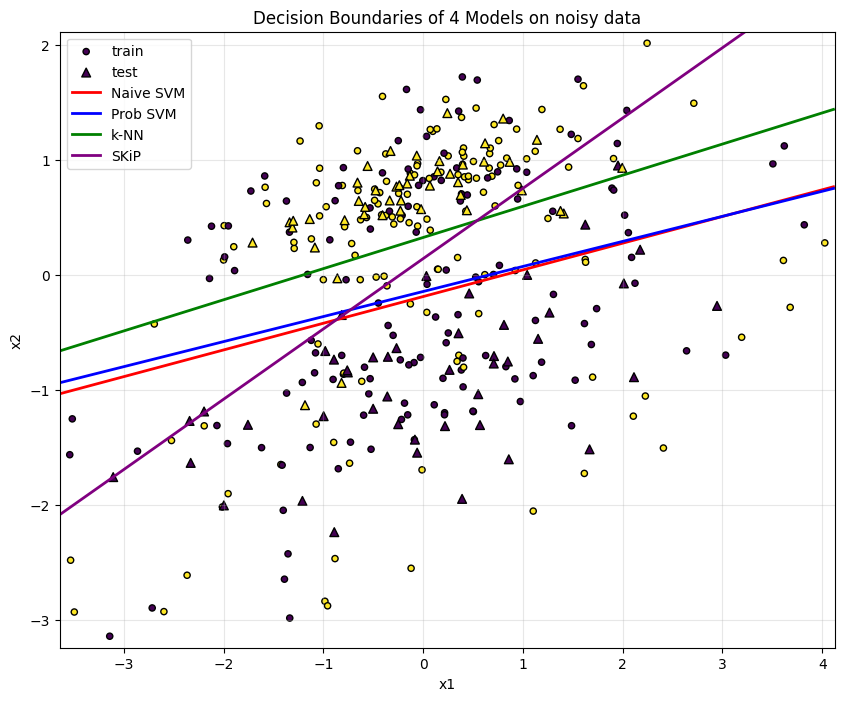

In [71]:
import numpy as np
import matplotlib.pyplot as plt

models = [
    ("Naive SVM", clf_naive),
    ("Prob SVM",  clf_prob),
    ("k-NN",      clf_knn),
    ("SKiP",      clf_skip),
]

xx, yy = np.meshgrid(
    np.linspace(X_noisy_train[:, 0].min() - 0.1, X_noisy_train[:, 0].max() + 0.1, 300),
    np.linspace(X_noisy_train[:, 1].min() - 0.1, X_noisy_train[:, 1].max() + 0.1, 300),
)
grid = np.c_[xx.ravel(), yy.ravel()]

plt.figure(figsize=(10, 8))

plt.scatter(X_noisy_train[:, 0], X_noisy_train[:, 1], c=y_noisy_train, s=20, edgecolor='k', label='train')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, marker='^', edgecolor='k', label='test')

colors = ['red', 'blue', 'green', 'purple']

legend_handles = []

for (name, clf), col in zip(models, colors):
    scores = clf.decision_function(grid)
    zz = scores.reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=[0], colors=[col], linewidths=2, label=name)
    h, = plt.plot([], [], color=col, linewidth=2, label=name)
    legend_handles.append(h)

plt.legend(handles=legend_handles + plt.gca().collections[:2], loc='upper right')

plt.legend()
plt.title("Decision Boundaries of 4 Models on noisy data")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(alpha=0.3)
plt.show()